In [1]:
from pathlib import Path
from tqdm import tqdm
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/khoa-ys/Projects/venv_for_projects/bio_ml_venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


### Load data and divide into train and test set:

In [2]:
root_path = os.path.dirname(os.getcwd())
data_path = os.path.join(root_path, "segmented_shortened_dataset")
image_dict = json.load(open(os.path.join(data_path, 'image_dict.json'), 'r'))
labels = []
image_paths = []
for key, item in list(image_dict.items()):
    for image_path in item:
        labels.append(list(image_dict.keys()).index(key))
        image_paths.append(image_path)
X_train, y_train = image_paths, labels
#X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.2, random_state=205)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=205)
#print(len(X_train), len(X_test))
print(*image_dict.keys(), sep=', ')

Astrocitoma, Carcinoma, Ependimoma, Glioblastoma, Meningioma, Neurocitoma, Oligodendroglioma, Papiloma, Schwannoma, _NORMAL


In [3]:
class BrainTumorDataset(Dataset):
    def __init__(self, data_path, image_paths, labels, transform=None, transform_label=None):
        self.data_path = data_path
        self.image_paths = image_paths
        self.image_class_list = labels
        self.transform = transform
        self.transform_label = transform_label

    def __len__(self):
        return len(self.image_class_list)

    def __getitem__(self, idx):
        label = self.image_class_list[idx]
        img_path = os.path.join(self.data_path, self.image_paths[idx])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if self.transform:
            image = self.transform(image)
        if self.transform_label:
            label = self.transform_label(label)
        return image, label

### VAE model:

In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
                                     nn.LeakyReLU(inplace=True),
                                     nn.Conv2d(16, 64, kernel_size=3, stride=2, padding=1),
                                     nn.LeakyReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                                     nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
                                     nn.LeakyReLU(inplace=True),
                                     nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
                                     nn.Conv2d(128, 512, kernel_size=3, stride=2, padding=0),
                                     nn.LeakyReLU(inplace=True))
        self.fc1 = nn.Linear(512*3*3, 128)
        self.fc_mu = nn.Linear(128, latent_dim)
        self.fc_log_var = nn.Linear(128, latent_dim)
        
        # Decoder
        self.fc2 = nn.Linear(latent_dim, 128)
        self.fc3 = nn.Linear(128, 512*15*15)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 15, 15))
        self.decoder = nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, output_padding=1),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(64, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.LeakyReLU(inplace=True),
                                     nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                                     nn.LeakyReLU(inplace=True))
        # self.softmax = nn.Softmax()
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
    
    def encode(self, x):
        x = self.encoder(x)
        #print(x.size())
        """
        batch, _, _, _ = x.shape
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = self.fc1(x)
        """
        x = torch.flatten(x, start_dim=1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        # get `mu` and `log_var`
        mu = self.fc_mu(x)
        log_var = self.fc_log_var(x)
        return mu, log_var
    
    def decode(self, sample):
        # decoding
        """
        z = self.fc2(sample)
        z = z.view(-1, 128, 1, 1)
        """
        z = F.relu(self.fc2(sample))
        z = F.relu(self.fc3(z))
        z = self.unflatten(z)
        #print(z.size())
        reconstruction = self.decoder(z)
        return reconstruction

### Training and evaluation

#### Hyperparameters set

In [5]:
learning_rate = 3e-3
batch_size = 32
epochs = 750
latent_dim = 64
weight = 0.5

#### Load dataset into Dataloaders

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: torch.Size([32])


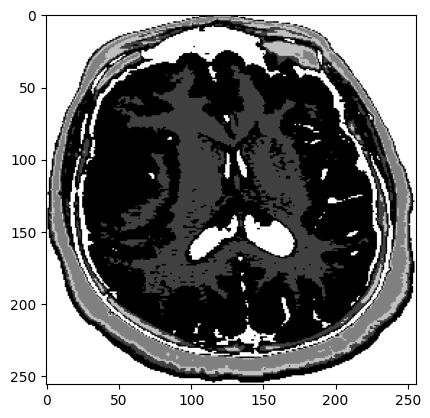

Label: 4


In [6]:
train_dataset = BrainTumorDataset(data_path, X_train, y_train, transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = BrainTumorDataset(data_path, X_test, y_test, transform=transforms.ToTensor())
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#val_dataset = BrainTumorDataset(data_path, X_val, y_val, transform=transforms.ToTensor())
#val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(image, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Load model and modify

In [7]:
model = VAE(latent_dim=latent_dim)
model.to(device)

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01, inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 512, kernel_size=(3, 3), stride=(2, 2))
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc_mu): Linear(in_features=128, out_features=64, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_feat

#### Training loop

In [8]:
MSE = nn.MSELoss(reduction='sum')
#params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

------------ Epoch: 0 ------------
Loss: 497903.060023
Time elapsed: 3.867354393005371
------------ Epoch: 1 ------------
Loss: 368451.839939
Time elapsed: 2.217998743057251
------------ Epoch: 2 ------------
Loss: 344265.735661
Time elapsed: 2.226003646850586
------------ Epoch: 3 ------------
Loss: 332628.859042
Time elapsed: 2.259366512298584
------------ Epoch: 4 ------------
Loss: 322937.945503
Time elapsed: 2.288961887359619
------------ Epoch: 5 ------------
Loss: 315148.433117
Time elapsed: 2.2477433681488037
------------ Epoch: 6 ------------
Loss: 312038.386814
Time elapsed: 2.2987232208251953
------------ Epoch: 7 ------------
Loss: 301984.933880
Time elapsed: 2.2825353145599365
------------ Epoch: 8 ------------
Loss: 297862.554640
Time elapsed: 2.411371946334839
------------ Epoch: 9 ------------
Loss: 294742.658394
Time elapsed: 2.3734636306762695
------------ Epoch: 10 ------------
Loss: 288391.201553
Time elapsed: 2.293577194213867
------------ Epoch: 11 ------------
Lo

Text(0.5, 0, 'Epoch')

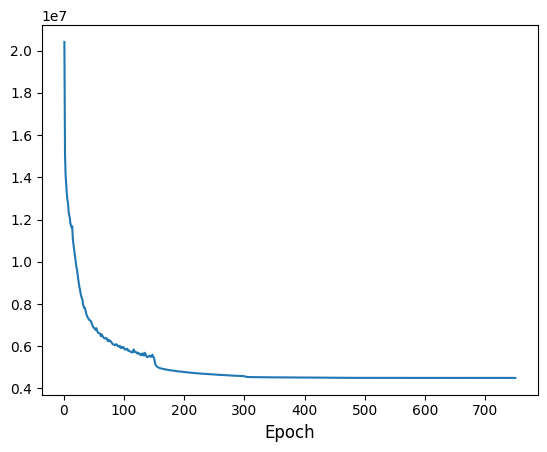

In [9]:
torch.cuda.empty_cache()
all_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)
for epoch in range(epochs):
    size = len(train_dataloader.dataset)
    print("------------ Epoch:", epoch, "------------")
    total_loss = 0
    start = time.time()
    for batch, (X, y) in enumerate(train_dataloader):
        X = X.to(device)
        mu, log_var = model.encode(X)
        KLD = weight*(-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()))
        sample = model.reparameterize(mu, log_var)
        reconstructed_X = model.decode(sample)
        #print(X.size(), reconstructed_X.size())
        MSE_loss = MSE(X, reconstructed_X)
        loss = KLD + MSE_loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #print(loss.item())
        total_loss += loss.item()
    scheduler.step()
    print(f"Loss: {total_loss/41:>7f}")
    end = time.time()
    print("Time elapsed:", end - start)
    all_loss.append(total_loss)

fig = plt.figure()
plt.plot(range(1, epochs+1), all_loss)
plt.xlabel('Epoch', fontsize=12)

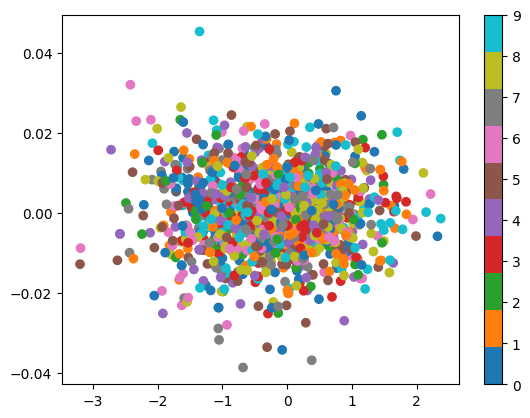

In [10]:
for batch, (X, y) in enumerate(train_dataloader):
    mu, log_var = model.encode(X.to(device))
    mu = mu.to('cpu').detach().numpy()
    plt.scatter(mu[:, 0], mu[:, 1], c=y, cmap='tab10')
    if batch > 41:
        plt.colorbar()
        break

In [15]:
reconstructed_image.size()

torch.Size([1, 1, 256, 256])

Feature batch shape: torch.Size([32, 1, 256, 256])
Labels batch shape: torch.Size([32])


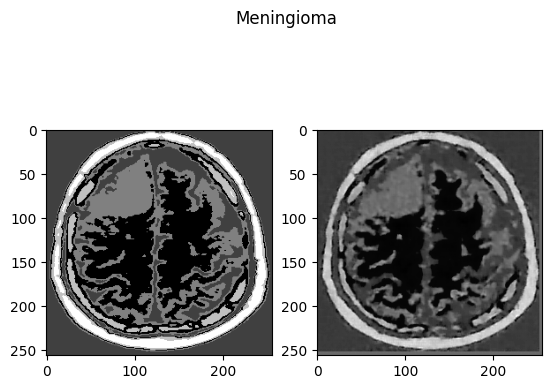

Label: 4


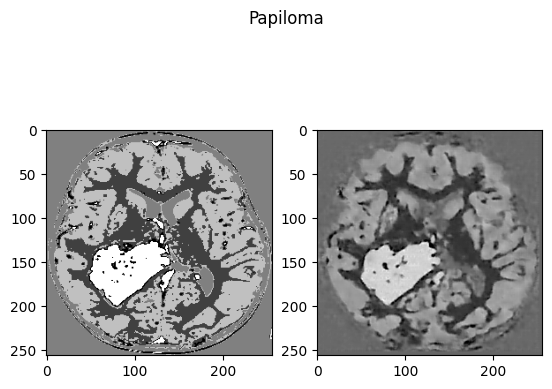

Label: 7


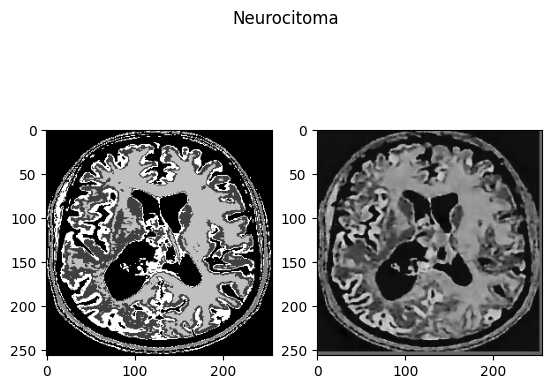

Label: 5


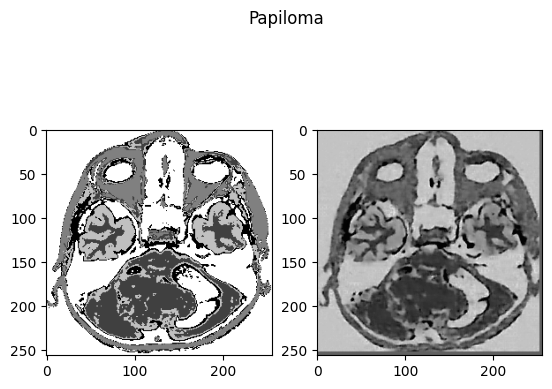

Label: 7


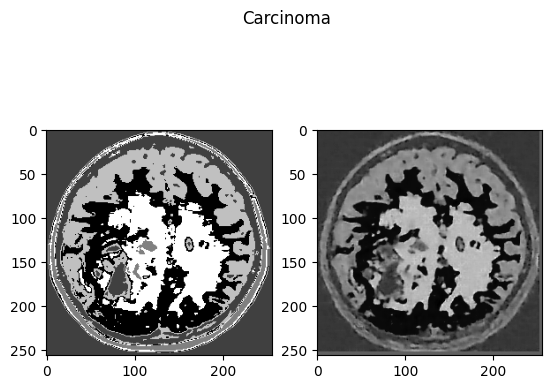

Label: 1


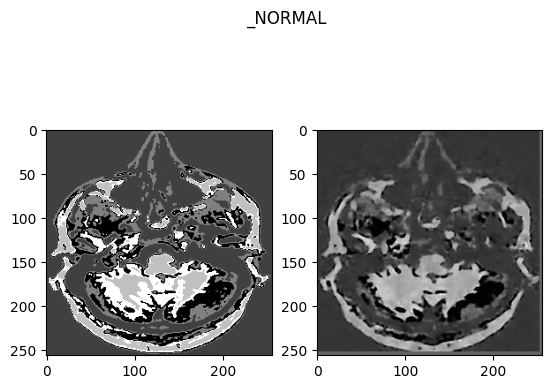

Label: 9


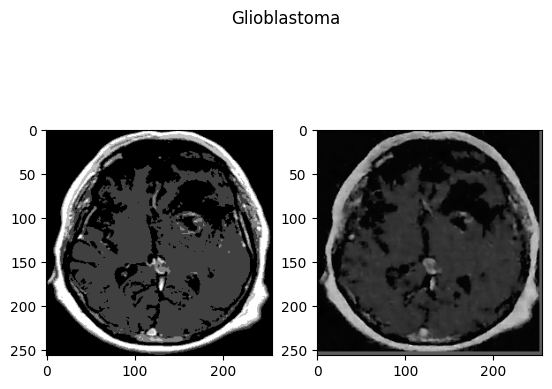

Label: 3


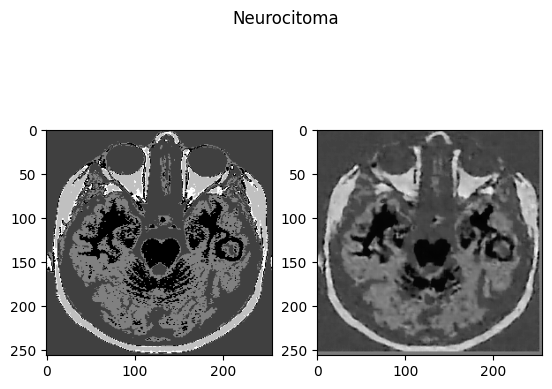

Label: 5


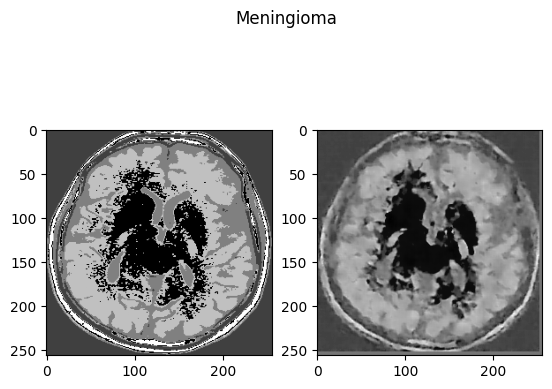

Label: 4


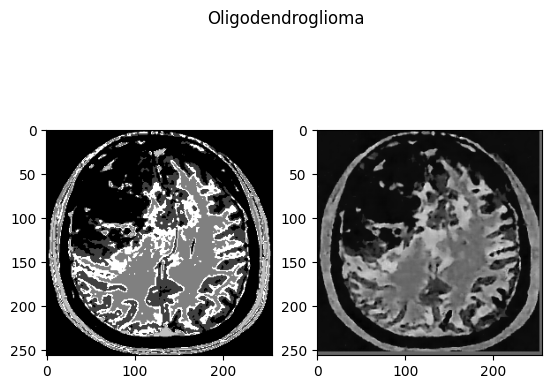

Label: 6


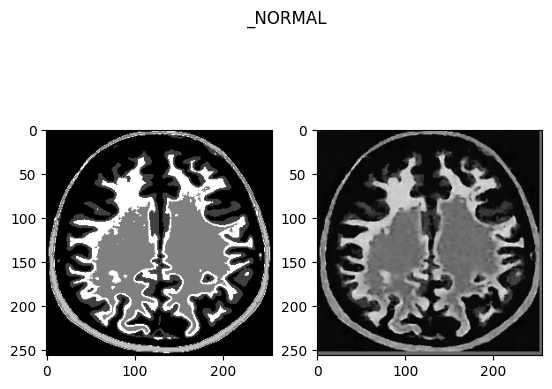

Label: 9


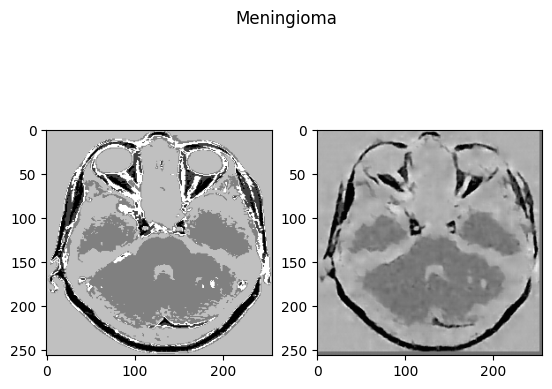

Label: 4


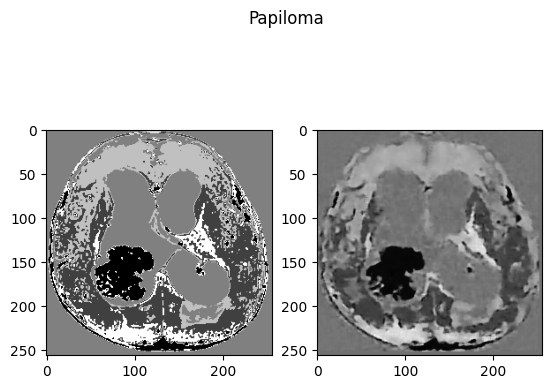

Label: 7


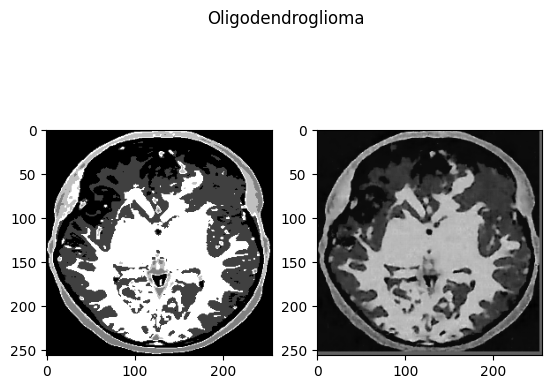

Label: 6


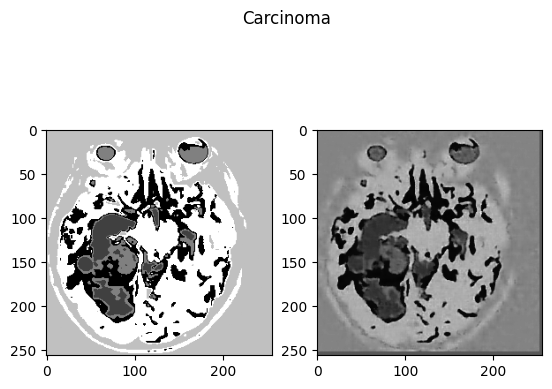

Label: 1


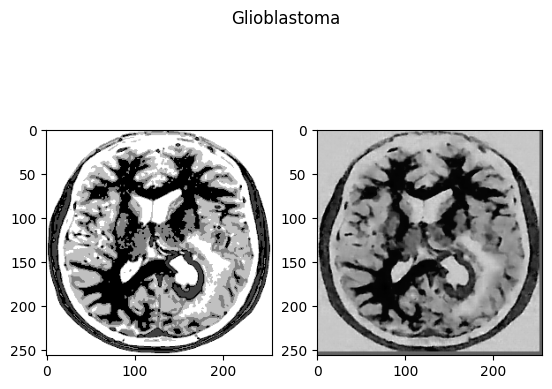

Label: 3


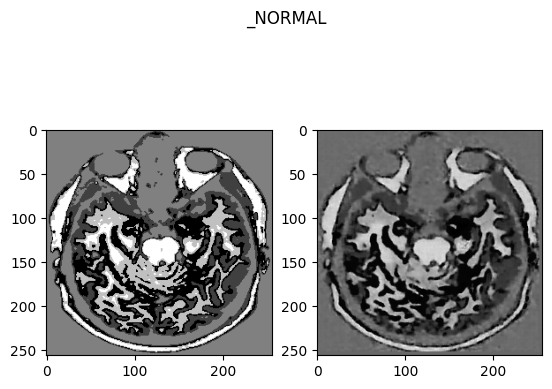

Label: 9


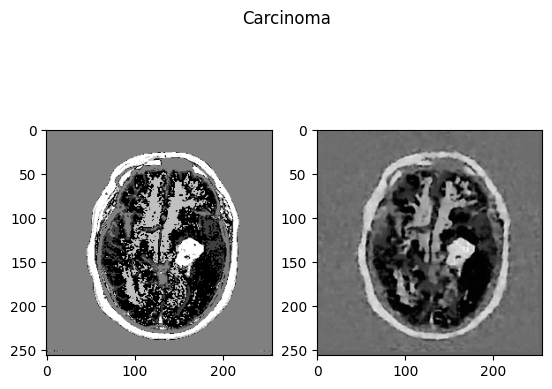

Label: 1


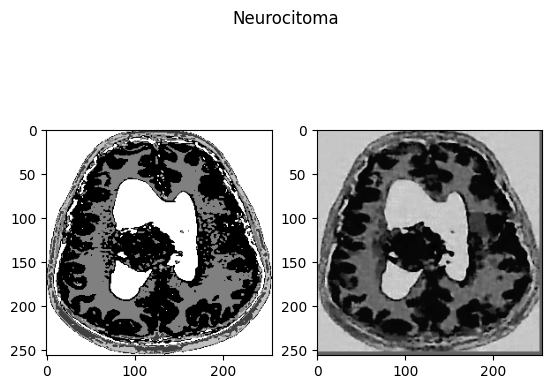

Label: 5


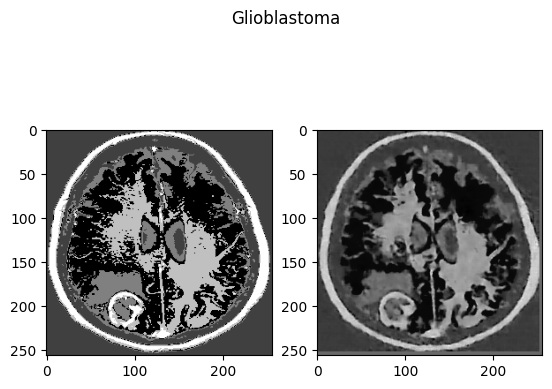

Label: 3


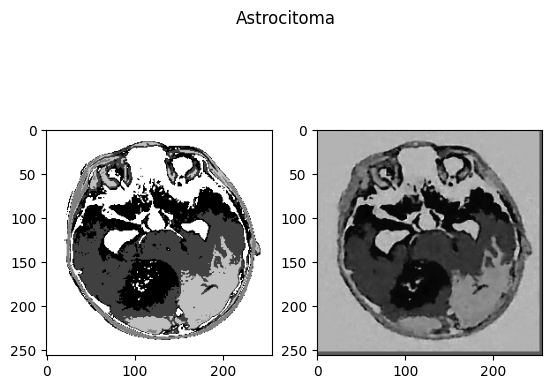

Label: 0


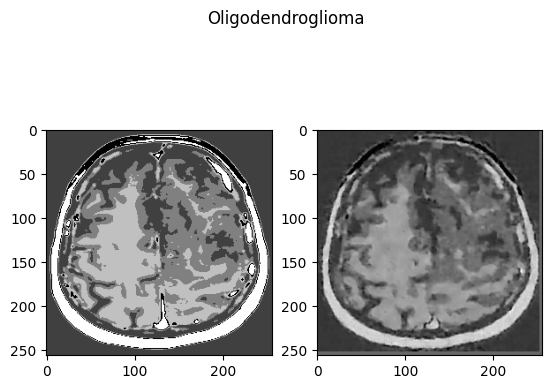

Label: 6


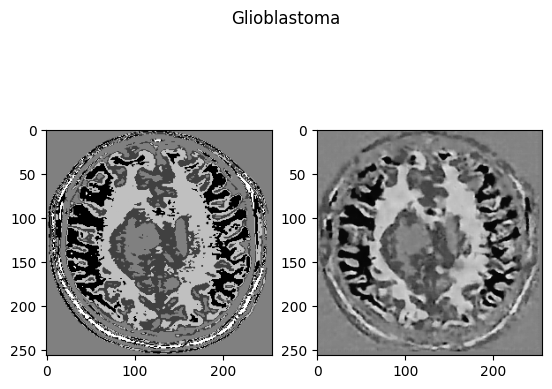

Label: 3


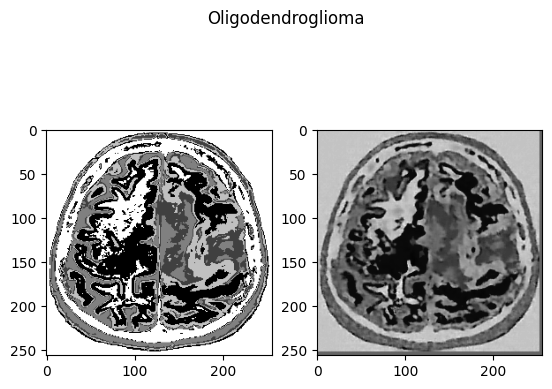

Label: 6


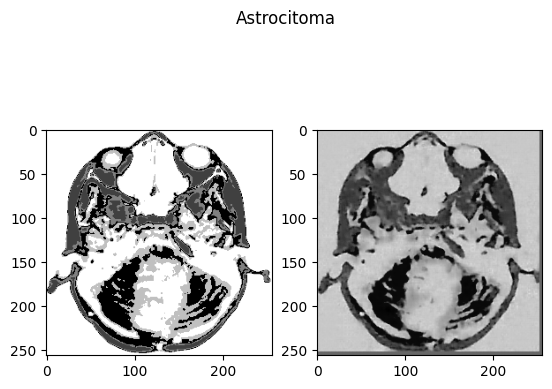

Label: 0


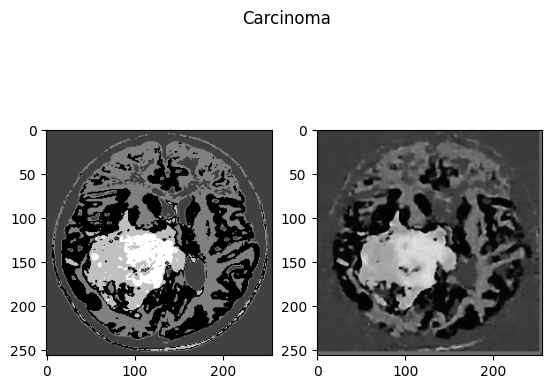

Label: 1


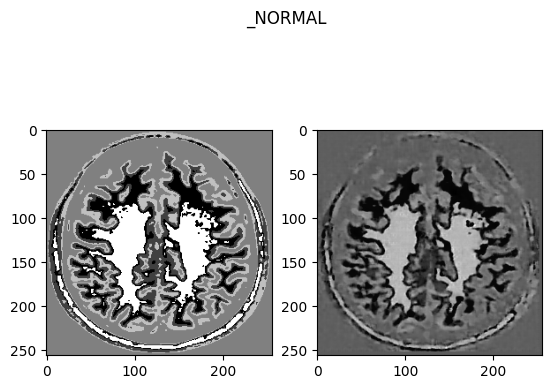

Label: 9


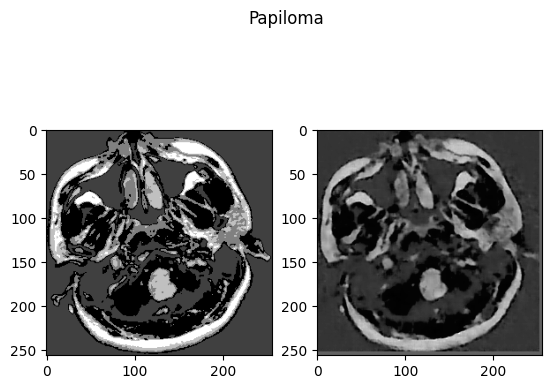

Label: 7


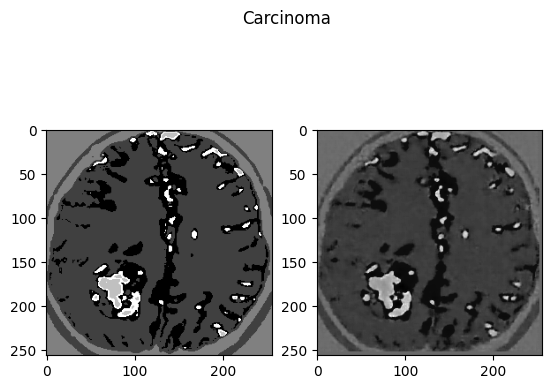

Label: 1


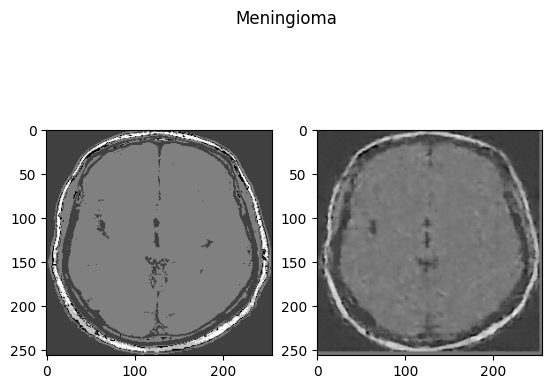

Label: 4


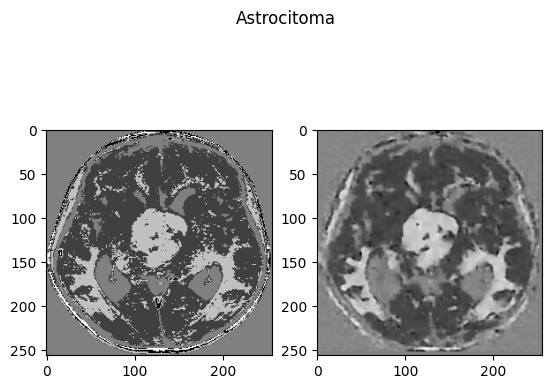

Label: 0


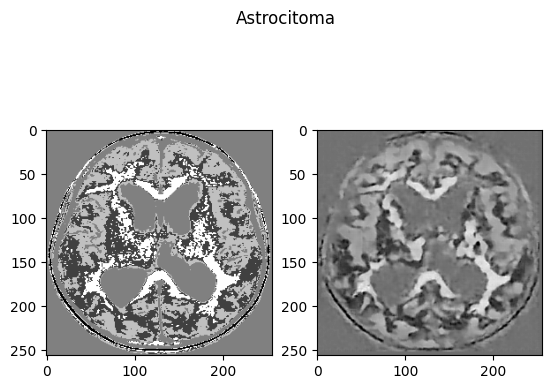

Label: 0


In [17]:
train_features, train_labels = next(iter(train_dataloader))
model.cpu()
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
for i in range(train_features.size()[0]):
    image = train_features[i]
    mu, log_var = model.encode(torch.unsqueeze(image, dim=0))
    sample = model.reparameterize(mu, log_var)
    reconstructed_image = model.decode(sample).detach().squeeze().squeeze().numpy()
    label = train_labels[i]
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(image.squeeze(), cmap="gray")
    ax[1].imshow(reconstructed_image, cmap="gray")
    fig.suptitle(list(image_dict.keys())[label])
    plt.show()
    print(f"Label: {label}")